<p style="font-size:30px; text-align:center"><b>Hull-White Model & Exact Simulation</b></p>
We review the Hull-White model for the short rate and illustrate how its integral can be simulated without any discretization error. The results are presented using the Python data science stack.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
import ipywidgets as wd
from mpl_toolkits import mplot3d
from scipy.stats import norm
import pandas as pd

import sys
sys.path.append("../../")
import pyqfin.models.hullwhite.globally_constant as hwg

# Theory
The 1F Hull-White model assumes that the short rate $r(t)$ is a stochastic process on a probability space $(\Omega, \mathcal{F}, \mathbb{P})$ as the solution of the SDE
\begin{align*}
    dr(t) = \kappa(t) (\vartheta(t) - r(t))dt  + \sigma(t) dW_t.
\end{align*}
Here, we are assuming that the *mean reversion* $\kappa(t) \equiv \kappa \in \mathbb{R}$ and the *volatility* $ \sigma(t) \equiv \sigma \in \mathbb{R}_{>0}$ are both constant.

## State Variable Formulation
Denoting by $f(0,t)$ the initial forward rate curve, it is often more convenient to simulate the *state variable*
\begin{align*}
    x(t) := r(t) - f(0,t)    
\end{align*}
instead. This satisfies SDE
\begin{align*}
    dx(t) = (y(t) - \kappa)x(t)dt + \sigma dW_t, && x(0)=0,
\end{align*}
where
\begin{align*}
    y(t) = \int_0^t{e^{-2\int_u^t{\kappa(s)ds}}\sigma(u)^2du} = \frac{\sigma^2}{2\kappa}( 1 - e^{-2 \kappa t}).
\end{align*}
The state variable $x(t)$ therefore is explicitly given for any $0 \leq s \leq t$ by
\begin{align}
    x(t) = e^{-\int_s^t{\kappa(\xi)d\xi}}x(s) +  \int_s^t{e^{-\int_u^t{\kappa(\xi)d\xi}}y(u)du} + \int_s^t{e^{-\int_u^t{\kappa(\xi)d\xi}}\sigma_r(u)dW}.
\end{align}
Thus, $x(t)$ can be simulated without any discretization error by recognizing that it is Gaussian and for and $0 \leq s \leq t$, its (conditional) moments are given by
\begin{align*}
    \mathbb{E}[x(t) \mid x(s)] &= e^{-\kappa (t-s)} x(s) + e^{- \kappa t} \frac{\sigma^2}{\kappa^2}\Big(\cosh(\kappa t) - \cosh(\kappa s) \Big), \\
    \mathbb{V}[x(t) \mid x(s)] &= \frac{\sigma^2}{2 \kappa} \Big(1 - e^{- 2 \kappa(t- s)} \Big), \\
    \mathbb{E}[x(t)] &= \frac{\sigma^2}{2 \kappa^2}\Big(1 - e^{- \kappa t} \Big)^2, \\
    \mathbb{V}[x(t)] &= \frac{\sigma^2}{2 \kappa} \Big(1 - e^{- 2 \kappa t} \Big), \\
    \operatorname{Cov}[x(s),x(t)] &= \frac{\sigma^2}{\kappa} e^{-\kappa t} \sinh(\kappa s).
\end{align*}

## Discount Factor
Simulating the short rate is often not enough for applications. In order to use it, we need the discount factor
\begin{align*}
    D(0,t) = e^{-\int_0^t{r(s)ds}} = e^{-\int_0^tf(0,s)ds} e^{- I(t)}, && I(t) := \int_0^tx(s)ds.
\end{align*}
In particular, we have to calculate the integral $I(t)$ over the short rate. It is of course always possible to choose a grid $0=t_0 < t_1 \ldots < t_N$ and compute this via numerical integration such as the trapezoid rule
\begin{align*}
    \tilde I(t) := \sum_{i=0}^{N-1}{\int_{t_i}^{t_{i+1}}{r(s)ds}} \approx \frac{1}{2} \sum_{i=0}^{N-1}{(r(t_{i+1}) + r(t_i))(t_{i+1} - t_i)}
\end{align*}
resulting in an approximate discount factor $\tilde D(0,t)$. However, this approximation of $I(t)$ is then subject to discretization error even if $x(t)$ is simulated without discretization error.

## Joint Simulation
We recognize that the integral $I(t)$ is also Gaussian, in fact $(x(t),I(t))$ is bi-variate Gaussian. Thus, we can simulate this 2D variable jointly. In order to perform this simulation, we calculate the moments 
\begin{align}
    \mathbb{E}[I(t) \mid I(s), x(s)] &= I(s) + x(s) G(s, t) + m_I(s,t) \\ 
    \mathbb{V}[I(t) \mid I(s), x(s)] &= 2 m_I(s,t) - y(s)G(s,t)^2 \\
    \operatorname{Cov}[x(t), I(t) \mid I(s), x(s)] &= \int_s^t{\int_s^u{\sigma(v)^2e^{- \int_v^u{\kappa(\xi)d\xi}} e^{-\int_v^t{\kappa(\xi)d\xi}} dv}du} = \frac{\sigma^2}{2 \kappa^2} \Big(1 - e^{- \kappa (t-s)}\Big)^2, \\
    \operatorname{Cov}[I(s),I(t)] &= \frac{\sigma^2}{\kappa^3} \Big( e^{-\kappa t} \sinh(\kappa s)  - 1 +e^{-\kappa s} - e^{-\kappa t}(e^{\kappa s}-1) + \kappa s  \Big), 
\end{align}
where
\begin{align*}
    m_I(s,t) &:= \int_s^t{\int_s^u{e^{-\int_v^u{\kappa(\xi)d\xi}}y(v)dv}du} =  \frac{\sigma^2}{4 \kappa^3} \Big( 2 \kappa (t-s)  - (e^{-2 \kappa t} - e^{-2 \kappa s})  + 4 \cosh(\kappa s) (e^{- \kappa t} - e^{- \kappa s}) \Big), \\
    G(t,T) &= \int_t^T{e^{-\int_t^u{\kappa(s)ds}}du} =  \frac{1}{\kappa} \Big( 1 - e^{-2 (t-s)} \Big).
\end{align*}
Notice that one can also calculate the cross-covariance
\begin{align*}
     \operatorname{Cov}[x(s),I(t)] &= e^{-s \kappa} \frac{\sigma^2}{\kappa^2}\Big(1 -e^{-\kappa (s\wedge t)}  - \kappa e^{-\kappa t}(s \wedge t)\Big).
\end{align*}

## Bond and Bond Options
The state variable $x(t)$ can be used to price zero coupon bonds using the *bond reconstitution formula*
\begin{align}
    P(t,T) = E[e^{-\int_t^T{r(s)ds}} \mid \mathcal{F}_t] =  \frac{P(0,T)}{P(0,t)} \exp\Big(-x(t) G(t,T) - \frac{1}{2} y(t) G(t,T)^2 \Big).
\end{align}

Using this formula, one can also price options on a bond $P(T_e, T_m)$  with strike $K$ via
\begin{align}
    V_{\text{call}}(t) &= P(t,T_m) \Phi(d_+) - P(t,T_e) K \Phi(d_-), \\
    V_{\text{put}}(t) &= P(t,T_e) K \Phi(-d_-) -  P(t,T_m) \Phi(-d_+), 
\end{align}
where
\begin{align}
    d_{\pm} &= \frac{1}{\sqrt{v_t}} \ln\Big( \frac{P(t,T_m)}{K P(t,T_e)} \Big) \pm \frac{\sqrt{v_t}}{2}  \\
    v_t &= \int_t^T{|\sigma_P(u, T_m) - \sigma_P(u,T_e)|^2du} = \sigma^2 G(T_e,T_m)^2  \frac{1 - e^{-2 \kappa (T_e- t)}}{2 \kappa}.
\end{align}

## Caplets and Floorlets
Caplets and floorlets can be priced exactly like bond options, but in this case
\begin{align}
    V_{\text{caplet}}(t) & = P(t,T_e) \Phi(-d_-) - (1 + K(T_m - T_e)) P(t, T_M)\Phi(-d_+), \\
    V_{\text{floorlet}}(t) & = (1  + K(T_m - T_e)) P(t,T + (T_m - T_e)) \Phi(d_+) - P(t,T_e) \Phi(d_-),
\end{align}
where
\begin{align*}
    d_{\pm} &= \frac{1}{\sqrt{v_t}} \ln\Big( \frac{(1 + (T_m - T_e) K)P(t,T_m)}{P(t,T_e)} \Big) \pm \frac{\sqrt{v_t}}{2}.
\end{align*}

# Simulation
We now simulate the Hull-White model in practice and illustrate the results

In [6]:
params = hwg.Params(kappa=0.015, sigma=0.008, f0=0.05)

ntimes = 5
time_grid = np.linspace(0, 10, ntimes)
npaths = 100000

hw = hwg.Simulation(params, time_grid, npaths)
hw.simulate()
hw.discretize()

## Short Rate

<IPython.core.display.Javascript object>


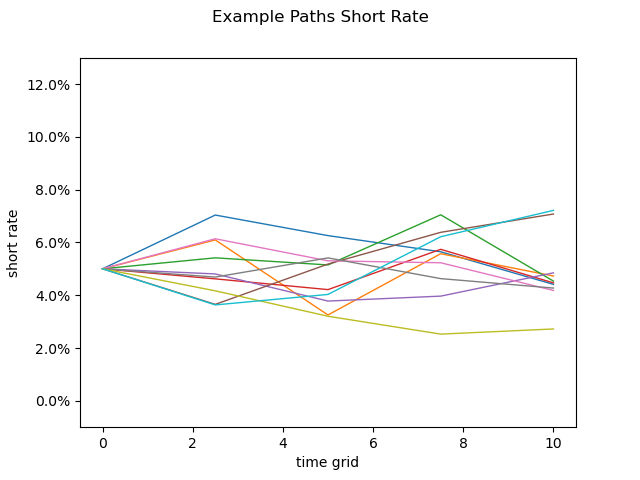

In [7]:
figpath, axpath = plt.subplots()
figpath.suptitle('Example Paths Short Rate')
axpath.plot(time_grid, hw.r_[:10, :].T * 100, lw=1)
axpath.yaxis.set_major_formatter(mtick.PercentFormatter())
axpath.set_xlabel('time grid')
axpath.set_ylabel('short rate')
axpath.set_ylim([-1, 13])
plt.show()

<IPython.core.display.Javascript object>


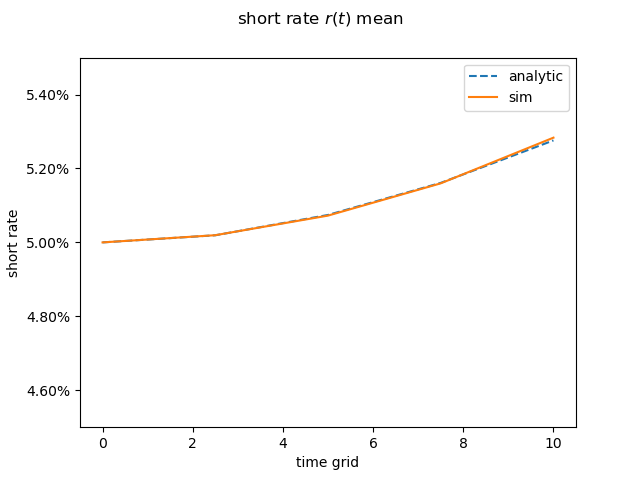

In [8]:
figmean, axmean = plt.subplots()
figmean.suptitle('short rate $r(t)$ mean')
axmean.plot(time_grid, hw.r_means() * 100, label='analytic', linestyle='--')
axmean.plot(time_grid, hw.r_.mean(axis=0) * 100, label='sim')
axmean.yaxis.set_major_formatter(mtick.PercentFormatter())
axmean.set_xlabel('time grid')
axmean.set_ylabel('short rate')
axmean.set_ylim([4.5, 5.5])
axmean.legend()
plt.show()

<IPython.core.display.Javascript object>


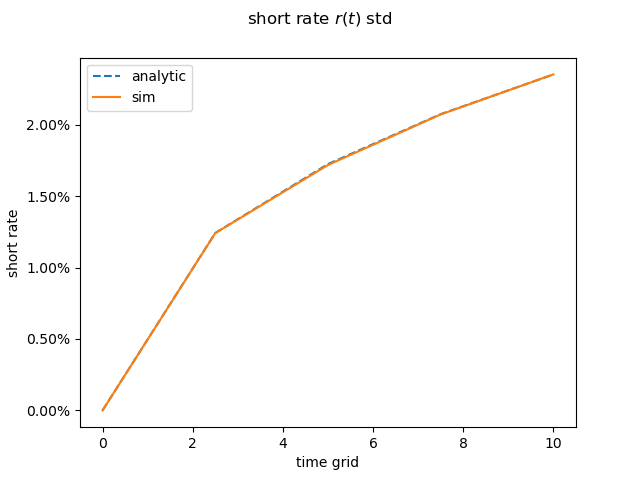

In [9]:
figvar, axvar = plt.subplots()
figvar.suptitle('short rate $r(t)$ std')
axvar.plot(time_grid, np.sqrt(hw.r_vars()) * 100, label='analytic', linestyle='--')
axvar.plot(time_grid, hw.r_.std(axis=0) * 100, label='sim')
axvar.yaxis.set_major_formatter(mtick.PercentFormatter())
axvar.set_xlabel('time grid')
axvar.set_ylabel('short rate')
axvar.legend()
plt.show()

<IPython.core.display.Javascript object>


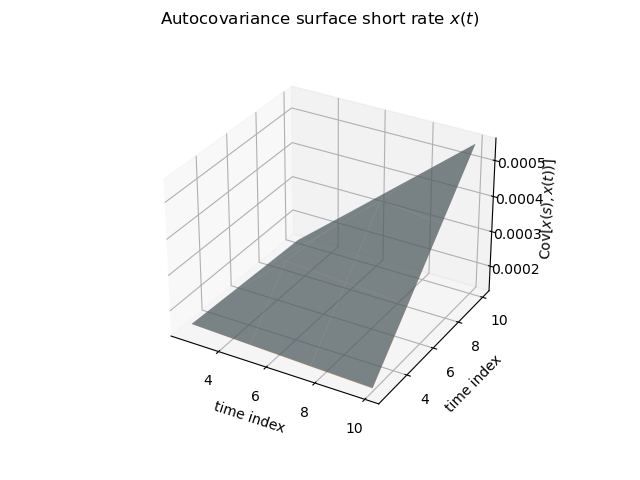

In [10]:
tx, ty = np.meshgrid(hw.time_grid[1:], hw.time_grid[1:])
figxcov = plt.figure()
figxcov.suptitle('Autocovariance surface short rate $x(t)$')
axxcov = plt.axes(projection="3d")
axxcov.plot_surface(tx, ty, hw.x_covs()[1:,1:], label='analytic', alpha=0.5)
axxcov.plot_surface(tx, ty, np.cov(hw.x_[:,1:].T), label='sim', alpha=0.5)
axxcov.set_xlabel('time index')
axxcov.set_ylabel('time index')
axxcov.set_zlabel('$\operatorname{Cov}[x(s), x(t))]$')
plt.show()

## Integrated State Variable

<IPython.core.display.Javascript object>


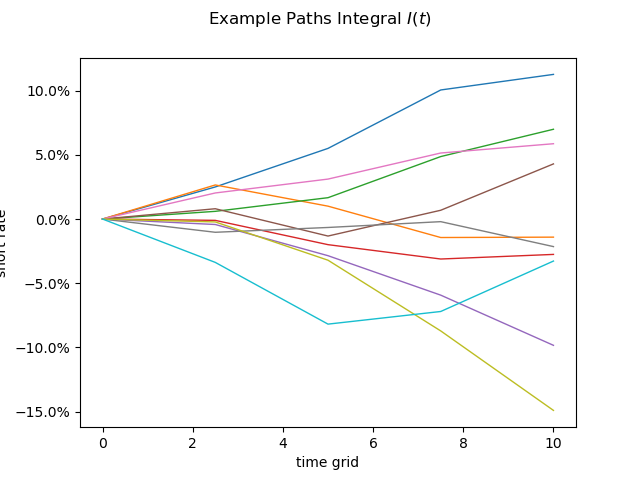

In [11]:
figIpath, axIpath = plt.subplots()
figIpath.suptitle('Example Paths Integral $I(t)$')
axIpath.plot(time_grid, hw.I_[:10, :].T * 100, lw=1)
axIpath.yaxis.set_major_formatter(mtick.PercentFormatter())
axIpath.set_xlabel('time grid')
axIpath.set_ylabel('short rate')
plt.show()

<IPython.core.display.Javascript object>


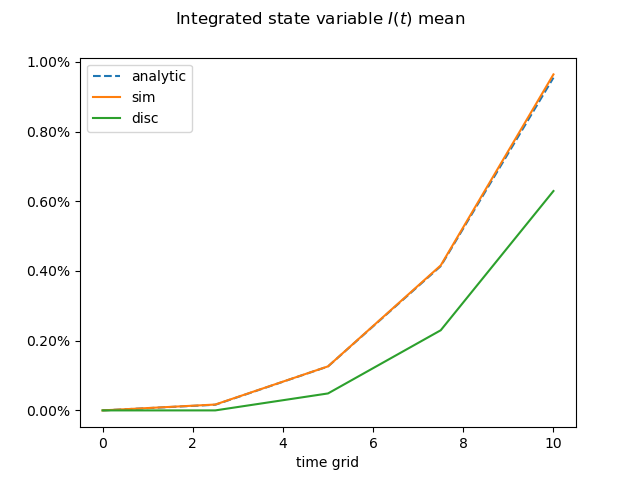

In [12]:
figmeanI, axmeanI = plt.subplots()
figmeanI.suptitle('Integrated state variable $I(t)$ mean')
axmeanI.plot(time_grid, hw.I_means() * 100, label='analytic', linestyle='--')
axmeanI.plot(time_grid, hw.I_.mean(axis=0) * 100, label='sim')
axmeanI.plot(time_grid, hw.I_disc_.mean(axis=0) * 100, label='disc')
axmeanI.set_xlabel('time grid')
axmeanI.yaxis.set_major_formatter(mtick.PercentFormatter())
axmeanI.legend()
plt.show()

This plot shows the advantage of simulating $I(t)$ jointly with $x(t)$: In situations where the simulation horizon is long and grid is spaced coarsely, the discretization error in computing $\hat I(t)$ is big, but the jointly simulated $I(t)$ still matches the analytic solution quite precisely.

<IPython.core.display.Javascript object>


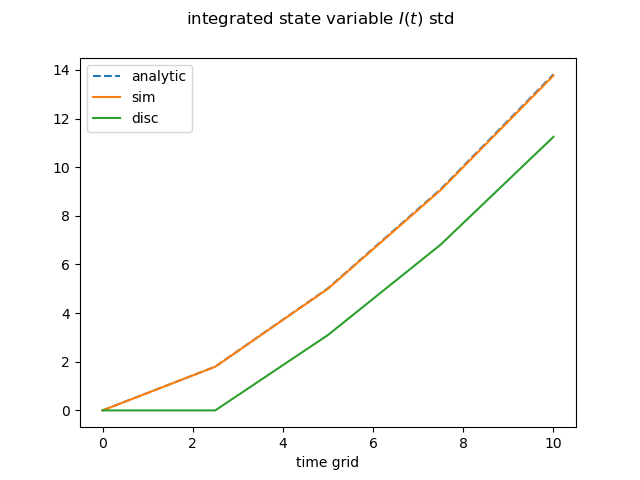

In [13]:
figstdI, axstdI = plt.subplots()
figstdI.suptitle('integrated state variable $I(t)$ std')
axstdI.plot(time_grid, np.sqrt(hw.I_vars()) * 100, label='analytic', linestyle='--')
axstdI.plot(time_grid, hw.I_.std(axis=0) * 100, label='sim')
axstdI.plot(time_grid, hw.I_disc_.std(axis=0) * 100, label='disc')
axstdI.set_xlabel('time grid')
axstdI.legend()
plt.show()

<IPython.core.display.Javascript object>


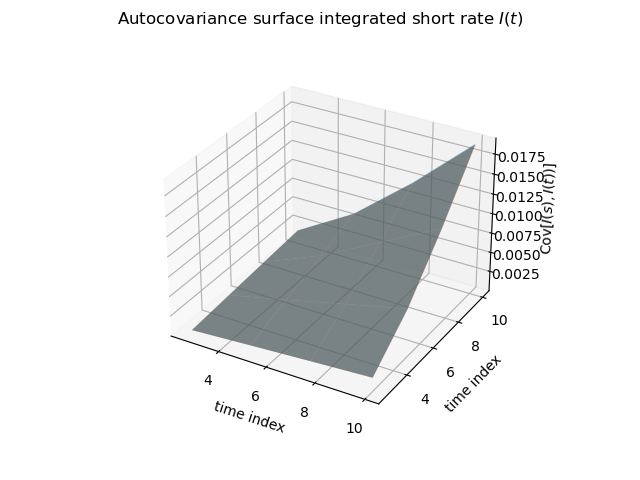

In [14]:
tx, ty = np.meshgrid(hw.time_grid[1:], hw.time_grid[1:])
figIcov = plt.figure()
figIcov.suptitle('Autocovariance surface integrated short rate $I(t)$')
axIcov = plt.axes(projection="3d")
axIcov.plot_surface(tx, ty, hw.I_covs()[1:,1:], label='analytic', alpha=0.5)
axIcov.plot_surface(tx, ty, np.cov(hw.I_[:,1:].T), label='sim', alpha=0.5)
axIcov.set_xlabel('time index')
axIcov.set_ylabel('time index')
axIcov.set_zlabel('$\operatorname{Cov}[I(s), I(t))]$')
plt.show()

<IPython.core.display.Javascript object>


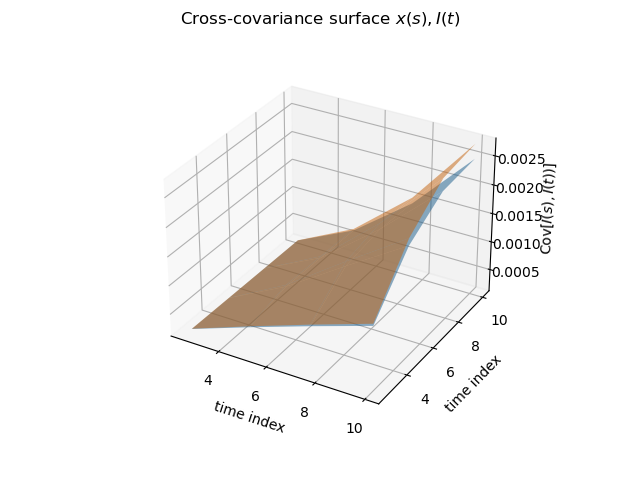

In [15]:
tx, ty = np.meshgrid(hw.time_grid[1:], hw.time_grid[1:])
figIcov = plt.figure()
figIcov.suptitle('Cross-covariance surface $x(s), I(t)$')
axIcov = plt.axes(projection="3d")
axIcov.plot_surface(tx, ty, hw.Ix_cross()[1:,1:], label='analytic', alpha=0.5)
axIcov.plot_surface(tx, ty, np.cov(hw.x_.T, hw.I_.T)[1:ntimes,ntimes+1:], label='sim', alpha=0.5)
axIcov.set_xlabel('time index')
axIcov.set_ylabel('time index')
axIcov.set_zlabel('$\operatorname{Cov}[I(s), I(t))]$')
plt.show()

## Discount Factor

<IPython.core.display.Javascript object>


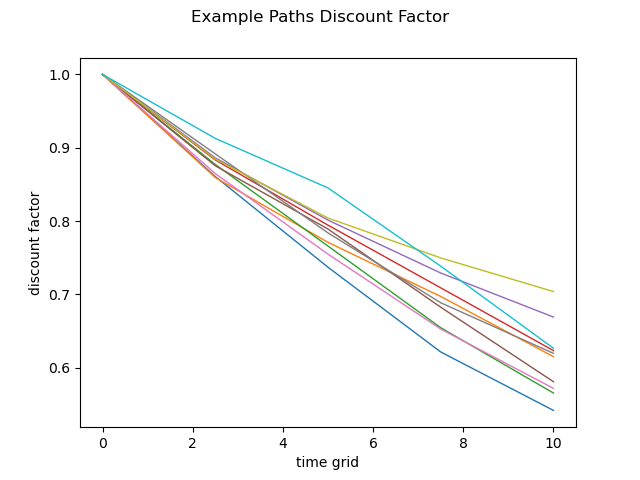

In [16]:
figpathdf, axpathdf = plt.subplots()
figpathdf.suptitle('Example Paths Discount Factor')
axpathdf.plot(time_grid, hw.df_[:10,:].T, lw=1)
axpathdf.set_xlabel('time grid')
axpathdf.set_ylabel('discount factor')
plt.show()

In [17]:
tx, ty = np.meshgrid(hw.time_grid, hw.time_grid)
PtT = np.ones((ntimes, ntimes))
for i in range(ntimes):
    for j in range(i):
        PtT[i,j] = hw.p(i,j).mean()

<IPython.core.display.Javascript object>


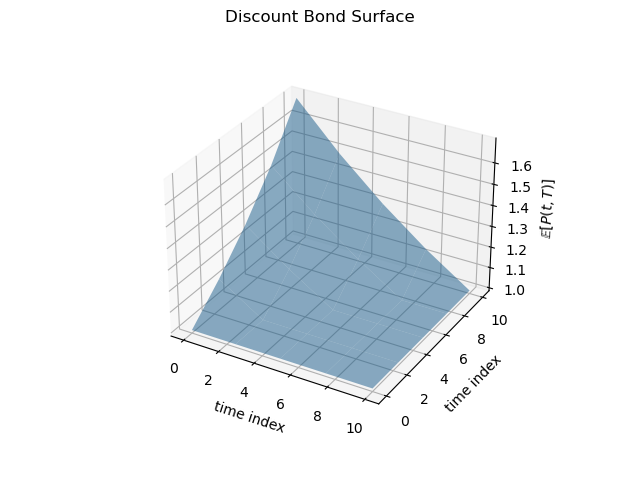

In [18]:
figp = plt.figure()
figp.suptitle('Discount Bond Surface')
axp = plt.axes(projection="3d")
axp.plot_surface(tx, ty, PtT, label='p', alpha=0.5)
axp.set_xlabel('time index')
axp.set_ylabel('time index')
axp.set_zlabel('$\mathbb{E}[P(t,T)]$')
plt.show()

## Caplet Pricing

In [19]:
k=0.04
caps_sim = np.zeros((ntimes, ntimes))
caps_analytic = np.zeros((ntimes, ntimes))
for i in range(ntimes):
    for j in range(i):
        caps_sim[i,j] = hw.price_mc_caplet(0,i,j,k).mean()
        caps_analytic[i,j] = hw.price_caplet(0,i,j,k).mean()

<IPython.core.display.Javascript object>


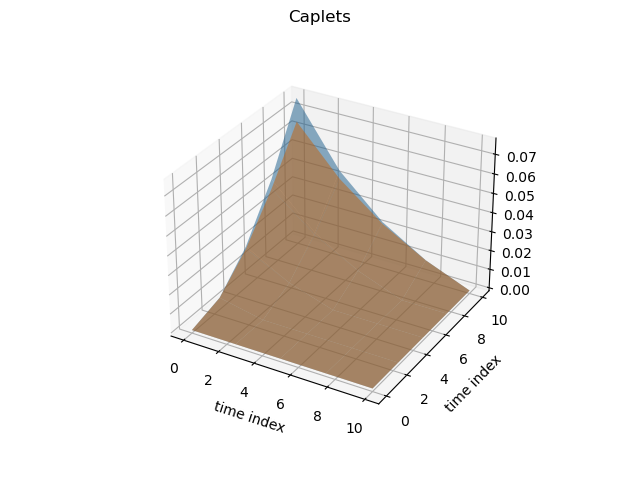

In [20]:
figcaps = plt.figure()
figcaps.suptitle('Caplets')
axcaps = plt.axes(projection="3d")
axcaps.plot_surface(tx, ty, caps_sim, label='sim', alpha=0.5)
axcaps.plot_surface(tx, ty, caps_analytic, label='analytic', alpha=0.5)
axcaps.set_xlabel('time index')
axcaps.set_ylabel('time index')
plt.show()

# References

* Andersen/Piterbarg: Interest Rate Modelling vol. 2
* Kienitz/Caspers: Interest Rate Derivatives Explained